# WSI - Ćwiczenie 5

*Autor: Maksymilian Nowak*

### Cel ćwiczenia

Celem ćwiczenia jest zaimplementowanie algorytmu Q-learning z $\varepsilon$-zachłanną strategią losowania akcji. Algorytm należy zastosować do wytrenowania agenta rozwiązującego problemu *Cliff Walking* dostępnego w pakiecie `gymnasium`.

Należy zbadać wpływ współczynnika dyskontowania ($\lambda$) i szybkości uczenia ($\beta$) na działanie algorytmu.

## Implementacja algorytmu

In [54]:
import numpy as np

def q_learning(env, episodes, _lambda, beta, epsilon, t_max=150):
    '''
    :param env: środowisko
    :param episodes: liczba epizodów
    :param _lambda: współczynnik dyskontowania
    :param beta: współczynnik uczenia
    :param epsilon: współczynnik eksploracji
    '''
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    steps = []
    for _ in range(episodes):
        # Ocena strategii
        sum_reward = 0
        step = 0

        # Właściwy algorytm
        state = env.reset()[0]
        done = False
        t = 0
        while t < t_max and not done:
            # Epsilon-zachłanna strategia
            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            next, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            sum_reward += reward
            step += 1
            Q[state][action] += beta * (reward + _lambda * np.max(Q[next]) - Q[state][action])
            state = next
            t += 1
        else:
            # Zapisanie wyników
            rewards.append(sum_reward)
            steps.append(step)

    return Q, rewards, steps


#### Inicjalizacja środowiska

In [55]:
import gymnasium as gym

env = gym.make('CliffWalking-v0')
Q, rewards, steps = q_learning(env, 300, 0.8, 0.5, 0.1)
print(Q)
print(rewards)
print(steps)

[[  -4.66972289   -4.68013739   -4.69158352   -4.69046189]
 [  -4.65388771   -4.62578091   -4.62265436   -4.66940517]
 [  -4.58147237   -4.55242256   -4.56670824   -4.60458729]
 [  -4.50209652   -4.46318286   -4.50299803   -4.51802571]
 [  -4.35151844   -4.3505845    -4.36773943   -4.35596021]
 [  -4.24952682   -4.20772157   -4.23972521   -4.43933542]
 [  -4.07348991   -4.04527671   -4.07787321   -4.03182221]
 [  -3.85616038   -3.84987547   -3.85128856   -3.931099  ]
 [  -3.66630497   -3.60843918   -3.59236232   -3.62371644]
 [  -3.43094702   -3.29707902   -3.32494587   -3.48593016]
 [  -3.03191506   -2.92847561   -2.91915827   -3.02078026]
 [  -2.77728706   -2.7743164    -2.43814332   -2.99546938]
 [  -4.70298647   -4.70103446   -4.6939862    -4.70912107]
 [  -4.6496743    -4.63932957   -4.6474972    -4.67328689]
 [  -4.58783955   -4.56183176   -4.5627189    -4.65256178]
 [  -4.47210881   -4.46093067   -4.46082442   -4.54021161]
 [  -4.36662569   -4.32798502   -4.3282872    -4.4764961

## Badanie wpływu parametrów na działanie algorytmu

### Współczynnik dyskontowania

Lambda: 0.01, średnia nagroda: -164.3135, średnia liczba kroków: 145.6454
Lambda: 0.05, średnia nagroda: -123.81946666666667, średnia liczba kroków: 98.94406666666667
Lambda: 0.1, średnia nagroda: -68.9592, średnia liczba kroków: 28.8741
Lambda: 0.15, średnia nagroda: -68.04673333333334, średnia liczba kroków: 27.592033333333333
Lambda: 0.2, średnia nagroda: -64.85893333333334, średnia liczba kroków: 26.595433333333332
Lambda: 0.25, średnia nagroda: -64.10216666666666, średnia liczba kroków: 25.927766666666667
Lambda: 0.3, średnia nagroda: -63.5862, średnia liczba kroków: 25.4316
Lambda: 0.35, średnia nagroda: -62.079366666666665, średnia liczba kroków: 24.964266666666667
Lambda: 0.4, średnia nagroda: -62.159166666666664, średnia liczba kroków: 24.707466666666665
Lambda: 0.45, średnia nagroda: -61.21456666666667, średnia liczba kroków: 24.373366666666666
Lambda: 0.5, średnia nagroda: -61.72513333333333, średnia liczba kroków: 24.190933333333334
Lambda: 0.55, średnia nagroda: -61.158933

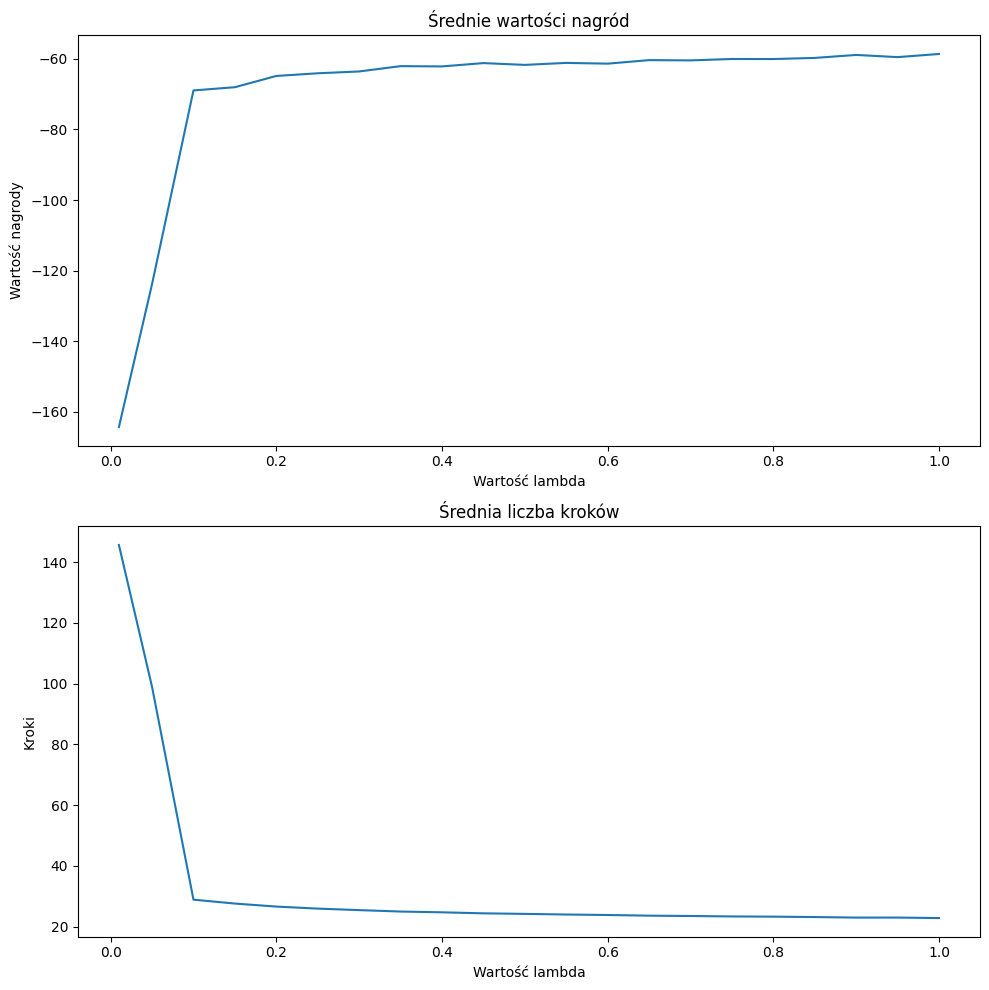

In [56]:
import matplotlib.pyplot as plt

def plot_lambda(values):
    rewards = []
    steps = []
    for _lambda in values:
        lambda_rewards = []
        lambda_steps = []
        for _ in range(100):
            _, r, s = q_learning(env, 300, _lambda, 0.5, 0.1)
            lambda_rewards.append(r)
            lambda_steps.append(s)
        avg_reward = np.mean(lambda_rewards)
        avg_steps = np.mean(lambda_steps)
        print(f'Lambda: {_lambda}, średnia nagroda: {avg_reward}, średnia liczba kroków: {avg_steps}')
        rewards.append(avg_reward)
        steps.append(avg_steps)
    fig, ax = plt.subplots(2, figsize=(10, 10))
    ax[0].plot(values, rewards)
    ax[0].set_xlabel('Wartość lambda')
    ax[0].set_ylabel('Wartość nagrody')
    ax[0].set_title('Średnie wartości nagród')
    ax[1].plot(values, steps)
    ax[1].set_xlabel('Wartość lambda')
    ax[1].set_ylabel('Kroki')
    ax[1].set_title('Średnia liczba kroków')
    plt.tight_layout()
    plt.show()

plot_lambda([0.01] + [round(0.05 * i, 2) for i in range(1, 21)])

### Współczynnik szybkości uczenia się

Beta: 0.01, średnia nagroda: -208.47503333333333, średnia liczba kroków: 124.28873333333334
Beta: 0.05, średnia nagroda: -119.33843333333333, średnia liczba kroków: 68.73623333333333
Beta: 0.1, średnia nagroda: -86.54306666666666, średnia liczba kroków: 46.718666666666664
Beta: 0.15, średnia nagroda: -75.73673333333333, średnia liczba kroków: 37.00463333333333
Beta: 0.2, średnia nagroda: -69.89333333333333, średnia liczba kroków: 32.147933333333334
Beta: 0.25, średnia nagroda: -67.209, średnia liczba kroków: 29.2194
Beta: 0.3, średnia nagroda: -64.3448, średnia liczba kroków: 27.2363
Beta: 0.35, średnia nagroda: -62.49203333333333, średnia liczba kroków: 25.799333333333333
Beta: 0.4, średnia nagroda: -61.0034, średnia liczba kroków: 24.7001
Beta: 0.45, średnia nagroda: -61.00443333333333, średnia liczba kroków: 23.945433333333334
Beta: 0.5, średnia nagroda: -60.13236666666667, średnia liczba kroków: 23.264766666666667
Beta: 0.55, średnia nagroda: -59.46516666666667, średnia liczba krok

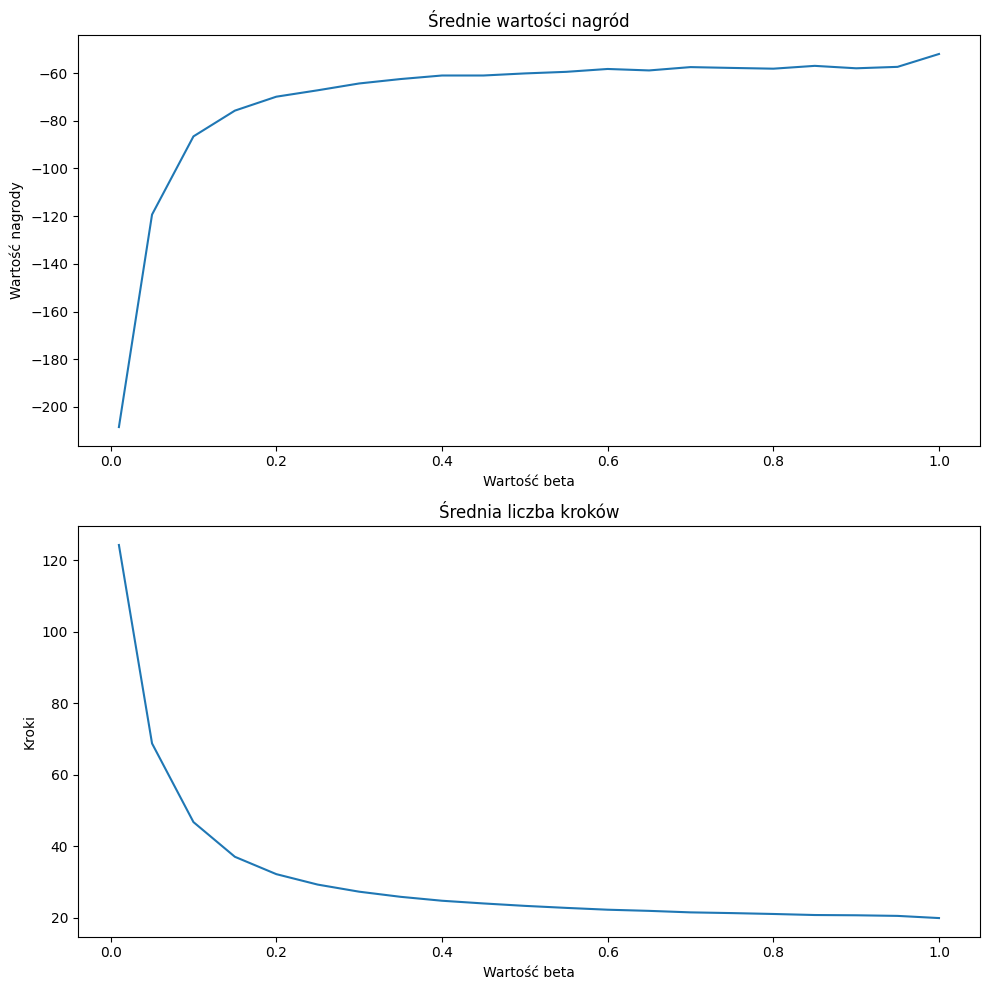

In [57]:
import matplotlib.pyplot as plt

def plot_beta(values):
    rewards = []
    steps = []
    for beta in values:
        beta_rewards = []
        beta_steps = []
        for _ in range(100):
            _, r, s = q_learning(env, 300, 0.8, beta, 0.1)
            beta_rewards.append(r)
            beta_steps.append(s)
        avg_reward = np.mean(beta_rewards)
        avg_steps = np.mean(beta_steps)
        print(f'Beta: {beta}, średnia nagroda: {avg_reward}, średnia liczba kroków: {avg_steps}')
        rewards.append(avg_reward)
        steps.append(avg_steps)
    fig, ax = plt.subplots(2, figsize=(10, 10))
    ax[0].plot(values, rewards)
    ax[0].set_xlabel('Wartość beta')
    ax[0].set_ylabel('Wartość nagrody')
    ax[0].set_title('Średnie wartości nagród')
    ax[1].plot(values, steps)
    ax[1].set_xlabel('Wartość beta')
    ax[1].set_ylabel('Kroki')
    ax[1].set_title('Średnia liczba kroków')
    plt.tight_layout()
    plt.show()

plot_beta([0.01] + [round(0.05 * i, 2) for i in range(1, 21)])